<a href="https://colab.research.google.com/github/suchakr/sandbox/blob/master/dp_sarpa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Setup
# libraries
!pip install --upgrade -q gspread
!pip install --upgrade -q matplotlib
!pip install --upgrade -q numpy
!pip install --upgrade -q seaborn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pprint
import re
pp = pprint.PrettyPrinter(indent=2)
import pandas as pd
import os
import os.path
import datetime as dt
from dateutil import parser




In [0]:
#@title Sample Plotly plot
import plotly.plotly as py
import numpy as np
from plotly.offline import iplot
from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
  init_notebook_mode(connected=False)

enable_plotly_in_cell()

x = np.random.randn(2000)
y = np.random.randn(2000)
iplot([Histogram2dContour(x=x, y=y, contours=Contours(coloring='heatmap')),
       Scatter(x=x, y=y, mode='markers', marker=Marker(color='white', size=3, opacity=0.3))], show_link=False)

In [0]:
#@title Load Data from Sheets

def cache_sheet_data(doc,sheet):
  #moon_standstill_phase_eclipse
  csv = './sample_data/' +sheet + '.csv'
  print(csv)
  if os.path.isfile(csv) :
    df = pd.read_csv(csv)
    return df
  
  from google.colab import auth
  auth.authenticate_user()

  import gspread
  from oauth2client.client import GoogleCredentials

  gc = gspread.authorize(GoogleCredentials.get_application_default())
  # You can open a spreadsheet by its title as it appears in Google Docs
  sh = gc.open(doc) # <-- Look ma, no keys!
  # Open our new sheet and read some data.
  ws = sh.worksheet(sheet)

  # get_all_values gives a list of rows.
  rows = ws.get_all_values()
  #print(rows)

  # Convert to a DataFrame and render.

  df = pd.DataFrame.from_records(rows[1:], columns=rows[0])
  df.to_csv(csv, index = None)
  return df


  

In [24]:
az_df_all = cache_sheet_data("dp-sarpa","Jaipur_Az")
ecl_df_all = cache_sheet_data("dp-sarpa","Jaipur_Lunar_Eclipse")

# populate daynum column
mr = az_df_all.loc[:,'MoonRise'] 
d0 = parser.parse(mr.iloc[0])
day_num =[]
for n in range(len(list(mr))):
  dn = parser.parse(mr.iloc[n])
  day_num.append((dn-d0).days)
az_df_all['days'] = pd.Series(day_num)

# find standstill span
standstill_start = az_df_all.loc[ az_df_all.Az == max(az_df_all.Az)].MoonRise
standstill_end = az_df_all.loc[ az_df_all.Az == min(az_df_all.Az)].MoonRise
#print ( standstill_start, standstill_end)

# mark the fullmoon and newmoon days
phases=list(az_df_all.loc[:,'Phase'])
fullmoon = [0]
newmoon= [0]
for n in list(range(1,len(phases)-1)) :
  prev, curr, next = phases[n-1], phases[n], phases[n+1]
  fullmoon.append(1 if  (curr >99 or (prev < curr and  next < curr)) else 0) # fullmoon when phases on earlier and next days are smaller
  newmoon.append(1 if  ( prev > curr and  next > curr) else 0) # newmoon when phases on earlier and next days are smaller
az_df_all['Fullmoon'] = pd.Series(fullmoon) 
az_df_all['Newmoon'] = pd.Series(newmoon) 

# slice one standstill of az dataframe
az_df_one_standstill = az_df_all.loc[standstill_start.index[0]-18.6*365 : standstill_start.index[0]+1*365]

# set indexes to date column
az_df_all = az_df_all.set_index("MoonRise")
az_df_one_standstill = az_df_one_standstill.set_index("MoonRise")
ecl_df_all = ecl_df_all.set_index("Calendar Date")

def add_eclipse_to_az(az_df, ec_df):
  eclipse = []
  for dt in az_df.index:
    et = 'x'
    if dt in ec_df.index:
      et = ec_df.loc[dt]['Ecl. Type']
    eclipse.append(1 if et == 'T' else 0.5 if et == 'P' else 0.1 if et == 'N' else 0)
  az_df['Eclipse'] = eclipse
  return az_df

add_eclipse_to_az(az_df_one_standstill , ecl_df_all )
add_eclipse_to_az(az_df_all , ecl_df_all )

az_df_all.to_csv ('./sample_data/Jaipur_Az_Eclipse')
"done"

./sample_data/Jaipur_Az.csv
./sample_data/Jaipur_Lunar_Eclipse.csv


'done'

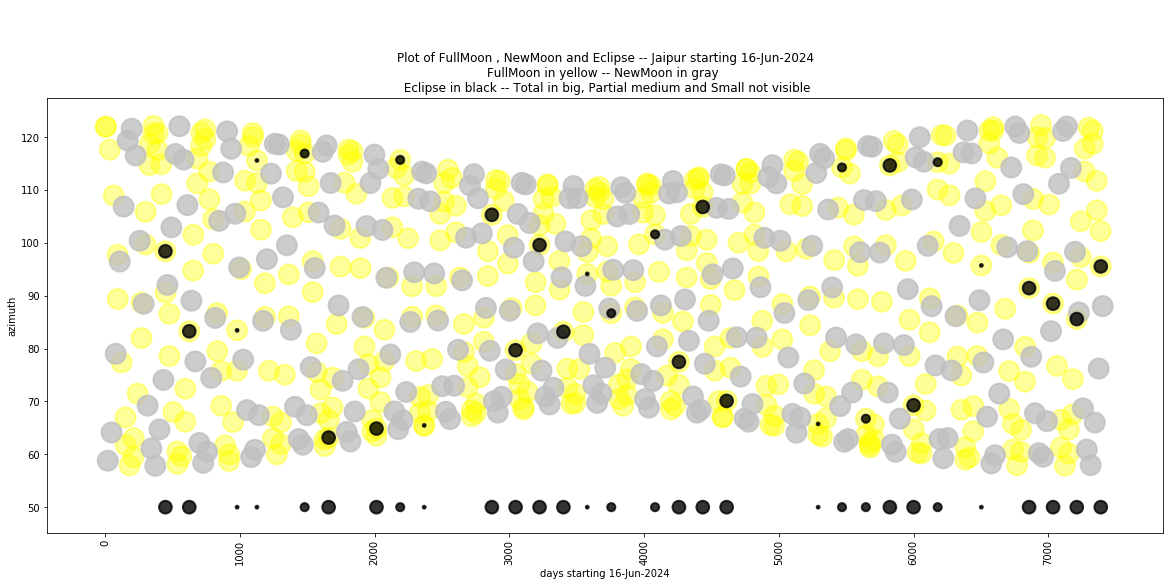

---


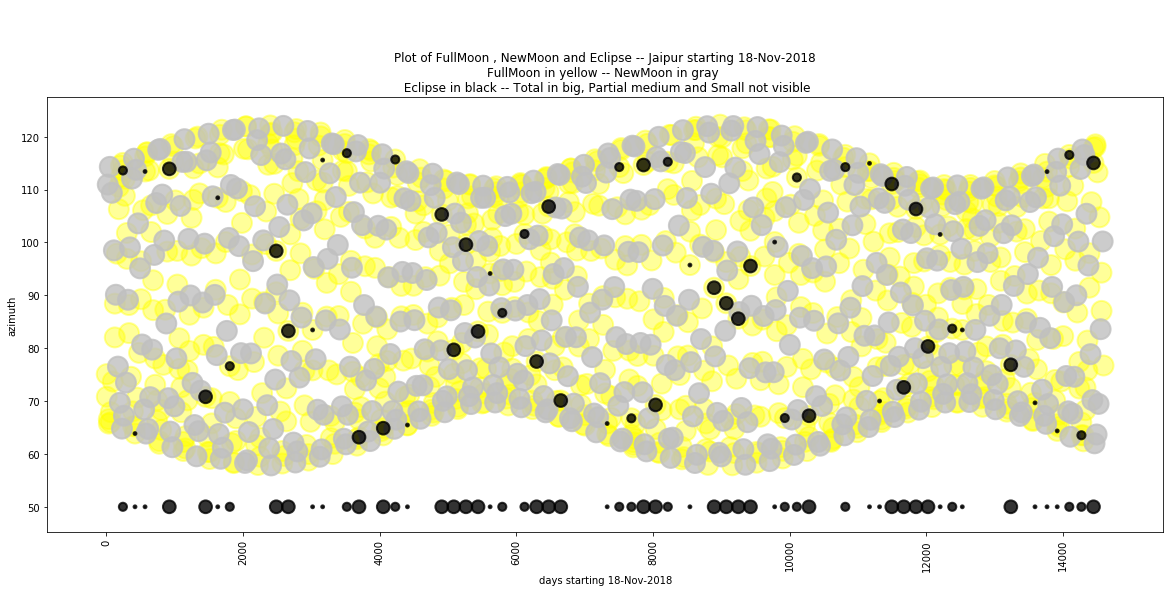

In [32]:
def do_plot(az_df):
  # create data
  #x = range(az_df.loc[:,'MoonRise'].size) #np.random.rand(15)
  day = az_df.loc[:,'days'] - az_df.loc[:,'days'][0]
  az = az_df.loc[:,'Az']        #x+np.random.rand(15)
    
  az_flat = az_df['Az'].map(lambda x: 50)

  fm = az_df.loc[:,'Fullmoon']*100
  nm = az_df.loc[:,'Newmoon']*100
  ec = az_df.loc[:,'Eclipse']*50
  # Change color with c and alpha. I map the color to the X axis value.
  #plt.scatter(x, y, s=z*20, c=x, cmap="Blues", alpha=0.4, edgecolors="grey", linewidth=2)

  plt.figure(figsize=(20,8))
  plt.scatter(day, az, s=fm**1.3, alpha=0.4, color="yellow", edgecolors="yellow", linewidth=2) 
  plt.scatter(day, az, s=nm**1.3, alpha=0.8, color="silver", edgecolors="silver", linewidth=2) 
  plt.scatter(day, az, s=ec**1.3, alpha=0.8, color="black", edgecolors="black", linewidth=2)
  plt.scatter(day, az_flat, s=ec**1.3, alpha=0.8, color="black", edgecolors="black", linewidth=2)
  plt.xlabel("days starting " + az_df.index[0])
  plt.ylabel("azimuth")
  plt.xticks( rotation='vertical')
  plt.title(
      ("\n\n\nPlot of FullMoon , NewMoon and Eclipse -- %s starting %s\n" % ('Jaipur' , az_df.index[0] ) )
      + "FullMoon in yellow -- NewMoon in gray \n Eclipse in black -- Total in big, Partial medium and Small not visible"
  ) 
  plt.show()

  if ( False):
    kaz_df = az_df[az_df.Paksha == 'Krishna']
    saz_df = az_df[az_df.Paksha == 'Shukla']
    kph = kaz_df.loc[:,'Phase']
    sph = saz_df.loc[:,'Phase']
    kaz = kaz_df.loc[:,'Az']
    saz= saz_df.loc[:,'Az']
    kday = kaz_df.loc[:,'days']
    sday = saz_df.loc[:,'days']
    plt.figure(figsize=(20,8))
    plt.scatter(kday, kaz, s=kph**1.2, alpha=0.4, color='lightcyan', edgecolors="grey", linewidth=2) 
    plt.scatter(sday, saz, s=sph**1.2, alpha=0.4, color='yellow', edgecolors="grey", linewidth=2) 
    plt.xlabel("azimuth")
    plt.ylabel("days")
    plt.xticks(rotation='vertical')
    plt.title("all phases") 
    plt.show()

do_plot(az_df_one_standstill)
print ("---")
do_plot(az_df_all)


In [11]:
az_df_all.index[0]



'18-Nov-2018'